# Problem Statement
1. Try different numbers of layers, and hiddent state sizes, to increase the accuracy of your MNIST classifier. What network seems to perform best? Are there any trends you notice in what works, or is there no relationship? Don't train for more than 10 epochs.

2. Take your best model and use the checkpoint option to save your models, and then load it back in and apply it to some of the MNIST test set. (Its OK to be using google on how to do that!)

3. Use PyTorch to load the CIFAR10 dataset (its OK if you need to google / read the docs for this!). Try to build a network that does well on this dataset. Do you get better/worse accuracy? Why do you think?

4. Re-do problem 3 (using CIFAR10) but use a Convolutional network. Did it perform better or worse? Why do you think?

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import time

Obtaining the MNIST data set from openml website using fetch_openml function.

In [0]:
from torch.utils.data import Dataset
from sklearn.datasets import fetch_openml

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)


Creating a simple dataset object. When we get an item, it grabs the correct row of the dataset and return the correct index and label on it. We can also define a 'len' function to find the shape of the tensor. PyTorch provides a helper function called Dataloader to load data, shuffling, and augmentations.

In [0]:
class SimpleDataset(Dataset):
        
    def __init__(self, X, y):
        super(SimpleDataset, self).__init__()
        self.X = X
        self.y = y
        
    
    def __getitem__(self, index):
        return self.X[index,:], int(self.y[index])

    def __len__(self):
        return self.X.shape[0]
training_loader = DataLoader(SimpleDataset(X, y), shuffle=True)

We define a function that would help us train, test and validate our model and also keep track of the performance(accuracy scores for training and validation) based on each epoch. Our code will support three different loaders. These will be:

The **training data loader**: This is what we use to adjust the weights of our network, based on the errors made.

The **testing data loader**: This data will be evaluated once at the end of training so that we can determine how well our model really did.

An optional **validation data loader**: This is another set of data not used for training, but which we use to score our performance after every epoch.


**Dynamic Metrics** :
We will use scikit learn metrics like accuracy score to evaluate the accuracy of our training, testing and validation processes.

**Saving Checkpoints**: 

In PyTorch, we are given a torch.load and torch.save function that can be used for this purpose. While there is more than one way to use these methods, we recommend using the dictionary style approach that you will see below. This lets us save the model, the optimizer state, and other information as well, all in one object.

We need to be able to save our model so that when we are ready to use it, we do not have to train if from scratch again! Saving after every epoch is a better idea though, especially when you start to train networks that can take weeks to complete. Sometimes, we may find that our code fails after many epochs, or a power failure interrupts our job. By saving the model after every epoch, we can resume our training from the last epoch, rather than having to start from scratch.

In [0]:
def train_simple_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=10, device="cuda",average='micro', checkpoint_file=None):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
    
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False):
      
            #Move the batch to the device we are using. 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            batch_size = inputs.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()
            inputs=inputs.float()
            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * inputs.size(0)
            
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                running_loss += loss.item() * inputs.size(0)

                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
                
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)




Splitting the dataset into training and testing sets.

In [0]:
dataset=SimpleDataset(X,y)
mnist_data_train = torchvision.datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


Lokking at an example image of the training set.

In [0]:
X_test,y_test= mnist_data_test[0]

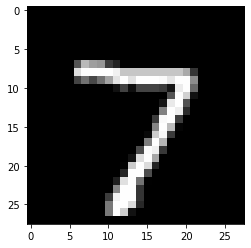

In [0]:
imshow(X_test[0],cmap='gray')

Now, I have built a basic neural network for training my model with 3 hidden layers. The number of input features is 28*28(number of features/pixels in each image). The numberr of neural nodes is upto us and can be varied with each layer. The output number must be the number of classes which we are predicting i.e; 10 in this case.

Now that we have designed our model, we call the train_simple_network function that will help us train our model. The loss function let us know how bad the model is performing and the direction it needs to head to acheive a lower loss. We use Cross Entropy Loss here, which is a combination of soft maximum loss and Cross entropy loss integrated into a single function. We have adjusted the number of epochs to 10 and calculating training loss and accuracy scores for training data. 

In [0]:
loss_func = nn.CrossEntropyLoss()
model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,200),
                    nn.Tanh(),
                    nn.Linear(200,80),
                    nn.Tanh(),
                    nn.Linear(80,10),
                    )
results_pd = train_simple_network(model, loss_func, training_loader, epochs=10,
                                  score_funcs={'Acc':accuracy_score
                                               })

In [0]:
results_pd

,epoch,total time,train loss,train Acc
0,0,85.234687,57274.738716,0.747586
1,1,170.152628,53167.103574,0.742357
2,2,255.504994,48703.013826,0.768200
3,3,340.681332,42637.490845,0.803371
4,4,425.957992,45173.493848,0.781129
5,5,511.469025,44507.856486,0.790857
6,6,596.135545,44028.449485,0.785314
7,7,680.258644,45710.965265,0.779929
8,8,764.424627,41712.405275,0.801157
9,9,848.600899,41081.250011,0.806200


Our model did mediocre. I have visualized the accuracy for each epoch in a seaborn lineplot.

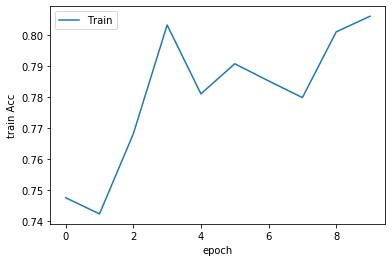

In [0]:
sns.lineplot(x='epoch', y='train Acc', data=results_pd, label='Train')

Lets try improving our performance by trying a different network. I resuced the number of layers,added a Sigmoid function and changed the number of nodes.

In [0]:
loss_func = nn.CrossEntropyLoss()

model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,400),
                    nn.Sigmoid(),
                    nn.Linear(400,10),
                    )
                    
results_pd_1 = train_simple_network(model, loss_func, training_loader, epochs=10,
                                  score_funcs={'Acc':accuracy_score
                                               })

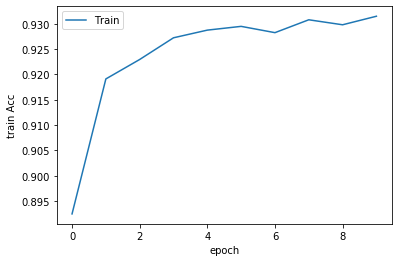

In [0]:
sns.lineplot(x='epoch', y='train Acc', data=results_pd_1, label='Train')

In [0]:
results_pd_1

,epoch,total time,train loss,train Acc
0,0,72.984898,29239.878646,0.892443
1,1,145.123281,20946.498917,0.919114
2,2,216.621578,19372.387093,0.922957
3,3,288.232586,18034.014956,0.927243
4,4,359.076855,17452.629642,0.928757
5,5,429.612128,17246.616409,0.929500
6,6,501.428057,17370.457673,0.928257
7,7,572.156090,16956.855553,0.930800
8,8,642.904896,16829.038814,0.929814
9,9,714.036124,16301.207912,0.931500


Our model performed better than the previous version with a good accuracy score. Let us change the sigmoid to a tanh function and see the performance.

In [0]:
loss_func = nn.CrossEntropyLoss()
testing_loader = DataLoader(mnist_data_test)
model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,31),
    nn.Tanh(),
    nn.Linear(31,10),
                    )
                    
results_pd_2 = train_simple_network(model, loss_func, training_loader, epochs=10,
                                  score_funcs={'Acc':accuracy_score
                                               })

In [0]:
results_pd_2

,epoch,total time,train loss,train Acc
0,0,73.469743,104992.787729,0.484671
1,1,146.575144,89548.642033,0.556686
2,2,218.217563,83884.670345,0.578643
3,3,289.480031,84173.843763,0.575429
4,4,361.047856,76577.242178,0.626543
5,5,432.928980,70834.491298,0.663000
6,6,504.674117,71325.243553,0.656171
7,7,576.210570,68753.644719,0.675100
8,8,646.995126,69259.243306,0.666500
9,9,718.276987,67174.070803,0.672629


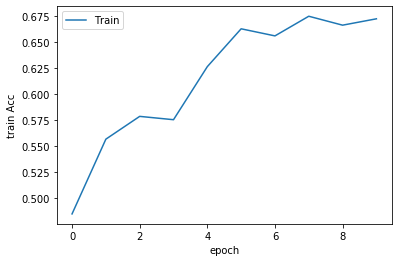

In [0]:
sns.lineplot(x='epoch', y='train Acc', data=results_pd_2, label='Train')

So changing our non-linear function has affected our performance costing us an accuracy loss of 25 percent.

So, based on these cases, I believe that hidden layers are helpful in increasing the performance of a model but only upto a certain extent. After a particluar point, the increased number of layers start hurting the model and have no major effect on its accuracy.

Also, the more specialized the weights will become to the training data, overfitting the training data. The weights will grow in size in order to handle the specifics of the examples seen in the training data. Large weights make the network unstable.

Since my second model perfromed the best with training data (93 % accuracy), I created a check point for this model. This way we can load the trained model directly in future to test, without requiring training. But once the kernel is refreshed, we lose the model. So it is handy to downlaod and upload the model when we need to load for testing it.

In [0]:
loss_func = nn.CrossEntropyLoss()
model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,400),
                    nn.Sigmoid(),
                    nn.Linear(400,10),
                    )
                    
results_pd_1 = train_simple_network(model, loss_func, training_loader, epochs=10, 
                                  checkpoint_file='MNISTmodel.pt',
                                  score_funcs={'Acc':accuracy_score
                                               })

One reason we use the torch.load and torch.save functions is the map_location argument that is used. This handles loading a model from the data to the correct compute device for us.

Once we load in the dictionary of results, we can use the load_state_dict function to restore the states of our original model into this new object.

In [0]:
model_new=nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,400),
                    nn.Sigmoid(),
                    nn.Linear(400,10),
                    )
checkpoint_dict = torch.load('MNISTmodel.pt', map_location='cuda')

model_new.load_state_dict(checkpoint_dict['model_state_dict'])

<All keys matched successfully>

Now that we have loaded our model successfully, let us test the model on our test_dataset using val_loader and see how it performs. It has a similar process as training with accuracy score to evaluate how well our model has done.

In [0]:
model_new = model_new.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            

results = {} #Initialize every item with an empty list
to_track=['val loss','val Acc'] # tracking validation loss and validation accuracy
for item in to_track:
  results[item] = []


y_true = []  # actual label values
y_pred = []  # predicted label values
running_loss = 0.0
val_loader=DataLoader(mnist_data_test)   # data for testing
loss_func=nn.CrossEntropyLoss()          # loss function to tell how badly we are doing
score_funcs={'Acc':accuracy_score}                                     
for inputs, labels in val_loader:
  inputs = inputs.to('cpu')               #Move the batch to the device we are using.
  labels = labels.to('cpu')

  inputs=inputs.float()

  y_hat = model_new(inputs)       

  loss = loss_func(y_hat, labels)
  running_loss += loss.item() * inputs.size(0)  #Now we are just grabbing some information we would like to have

  labels = labels.detach().cpu().numpy()    #moving labels & predictions back to CPU for computing / storing predictions
  y_hat = y_hat.detach().cpu().numpy()
  batch_size = inputs.shape[0]

  for i in range(batch_size):
    y_true.append(labels[i])
    y_pred.append(y_hat[i,:])
                        
results["val loss"].append( running_loss )

y_pred = np.asarray(y_pred)

if y_pred.shape[1] > 1:   #We have a classification problem, convert to labels
  y_pred = np.argmax(y_pred, axis=1)

for name, score_func in score_funcs.items():
  results["val " + name].append( score_func(y_true, y_pred) )
            
print('The validation accuracy of the model is',results['val Acc'])      # Printing the validation accuracy based on the testing dataset    

The validation accuracy of the model is [0.9181]


Our model did fairly well with a training accuracy of 93.15 and a validation accuracy of 91.81.

I referred to https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html for the following lines of code.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

#CIFAR Datset

Loading and normalizing the CIFAR10 training and test datasets using torchvision. 

A simple answer to why normalization should be performed is somewhat related to activation functions. Normalize function takes data, x, and returns it as a normalized Numpy array. x can be anything, it can be N-dimensional array. In this project, it will be 3-D array for an image. Min-Max Normalization (y = (x-min) / (max-min)) technique is used. By applying Min-Max normalization, the original image data is going to be transformed in range of 0 to 1 (inclusive). 

For example, sigmoid activation function takes an input value and outputs a new value ranging from 0 to 1. When the input value is somewhat large, the output value easily reaches the max value 1. Similarly, when the input value is somewhat small, the output value easily reaches the max value 0.

We further split the CIFAR Dataset into training and testing datasets with 50000 in training and 10000 imgaes in testing with 10 classes. 

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


We are defining a function that can help us display the sample images.

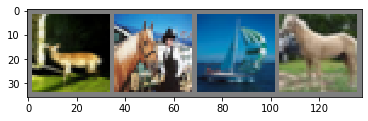

 deer horse  ship horse


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

I tried displaying a sample image to look at how it is potrayed as an RGB. I wasn't sure which cmap to use to display it more visually appealing.

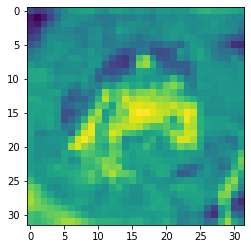

In [0]:
x_example,y_example=trainset[0]
x_example.shape
plt.imshow(x_example[0])

I used the previous function to train our model on this CIFAR 10 dataset. 


In [0]:
def train_simple_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=10, device="cuda", checkpoint_file=None):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
    
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False):
      
            #Move the batch to the device we are using. 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            batch_size = inputs.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()
            inputs=inputs.float()
            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * inputs.size(0)
            
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                running_loss += loss.item() * inputs.size(0)

                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
                
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)




I designed a simple network model using full connected neural networks to train and test the performance on the CIFAR10 datasets.

In [0]:
loss_func = nn.CrossEntropyLoss()
testing_loader = testloader

model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32,20),
    nn.Tanh(),
    nn.Linear(20,10),
    )
results_CIFR= train_simple_network(model,loss_func,train_loader=trainloader,val_loader=testloader,epochs=10,device='cuda',
                     checkpoint_file='CIFARmodel.pt',
                     score_funcs={'Acc':accuracy_score})

In [0]:
results_CIFR

,epoch,total time,train loss,val loss,train Acc,val Acc
0,0,36.042528,94763.457202,17945.801475,0.34646,0.3815
1,1,72.448713,87914.827559,17279.804359,0.39308,0.4005
2,2,108.524934,85249.094646,16984.702025,0.40974,0.4091
3,3,145.385077,83530.083670,16799.961096,0.42248,0.4151
4,4,182.000656,82286.759186,16634.520926,0.43254,0.4169
5,5,219.208471,81270.131749,16558.741852,0.43904,0.4227
6,6,255.375763,80417.184566,16478.256650,0.44534,0.4267
7,7,291.422382,79677.831909,16367.347796,0.45028,0.4313
8,8,327.420714,79011.171262,16366.870630,0.45482,0.4306
9,9,363.304568,78497.493387,16333.122065,0.45762,0.4290


Our fully connected neural netowork model had a training accuracy of 45.76 and testing accuracy of 42.90 which is quite low. Let us visualize the accuracy performance for training and test data.

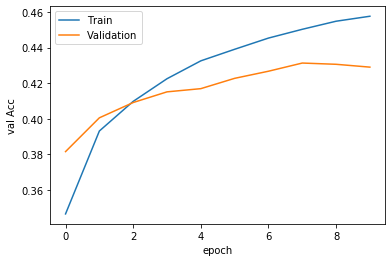

In [0]:
sns.lineplot(x='epoch', y='train Acc', data=results_CIFR, label='Train')
sns.lineplot(x='epoch', y='val Acc', data=results_CIFR, label='Validation')

Just after 2 epochs, our model failed to keep up with training accuracy. It failed to predict a correct image more than half the times. Let us tweak this network a little and see its affect on accuracy.

In [0]:
loss_func = nn.CrossEntropyLoss()
testing_loader = testloader

model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32,500),
    nn.Tanh(),
    nn.Linear(500,10),
    )
results_CIFR_1= train_simple_network(model,loss_func,train_loader=trainloader,val_loader=testloader,epochs=10,device='cuda',
                     checkpoint_file='CIFARmodel_1.pt',
                     score_funcs={'Acc':accuracy_score})

In [0]:
results_CIFR_1

,epoch,total time,train loss,val loss,train Acc,val Acc
0,0,41.721931,91989.144982,17485.675652,0.36438,0.4011
1,1,82.486145,86487.472207,17103.846242,0.40556,0.4103
2,2,122.342482,84230.316520,16839.303700,0.42196,0.4158
3,3,163.023582,82376.963436,16584.589043,0.43476,0.4287
4,4,203.210007,80741.704574,16291.838559,0.44828,0.4397
5,5,242.951185,79207.452128,16233.259792,0.46000,0.4382
6,6,282.548974,77716.177610,15902.537633,0.47004,0.4508
7,7,322.658011,76233.596299,15747.581093,0.48048,0.4598
8,8,361.594383,74743.029279,15559.504241,0.49100,0.4654
9,9,400.522879,73309.219742,15568.278314,0.50112,0.4671


Increasing number of nodes didn't really improve our performance.

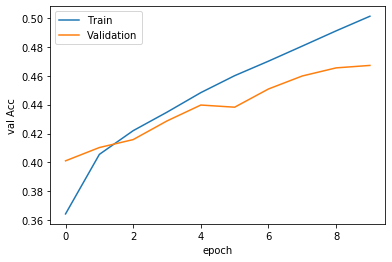

In [0]:
sns.lineplot(x='epoch', y='train Acc', data=results_CIFR_1, label='Train')
sns.lineplot(x='epoch', y='val Acc', data=results_CIFR_1, label='Validation')

In this case, I kept the number of nodes similar but increased the number of layers in the network.

In [0]:
loss_func = nn.CrossEntropyLoss()
testing_loader = testloader

model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32,500),
    nn.Tanh(),
    nn.Linear(500,300),
    nn.Sigmoid(),
    nn.Linear(300,10)
    )
results_CIFR_2= train_simple_network(model,loss_func,train_loader=trainloader,val_loader=testloader,epochs=10,device='cuda',
                     checkpoint_file='CIFARmodel_2.pt',
                     score_funcs={'Acc':accuracy_score})

In [0]:
results_CIFR_2

,epoch,total time,train loss,val loss,train Acc,val Acc
0,0,43.713767,105037.577471,19565.012570,0.24554,0.3081
1,1,86.475417,95356.986131,18599.588140,0.32324,0.3454
2,2,128.731131,91769.450510,18026.359788,0.35310,0.3691
3,3,171.207397,89390.756043,17670.731236,0.36890,0.3794
4,4,211.859518,87654.238597,17387.987454,0.38246,0.3866
5,5,253.701224,86256.727984,17116.790926,0.39470,0.4004
6,6,295.338647,85118.011499,16959.825790,0.40392,0.4060
7,7,338.279201,84110.015547,16824.995206,0.41198,0.4105
8,8,379.901250,83195.289213,16718.771714,0.41874,0.4151
9,9,421.942857,82316.286740,16551.276365,0.42852,0.4224


I expected the model to perform better since I had added extra layers but this was not the case. The accuracy declined. I believe the reason for this declined performance on the CIFAR 10 dataset when compared to MNIST dataset is that MNIST data set had fewer features in their images with every image being in grey scale and classes being digits. Whereas, images in CIFAR10 are RGB images with increased features which fully connected network could not learn. 

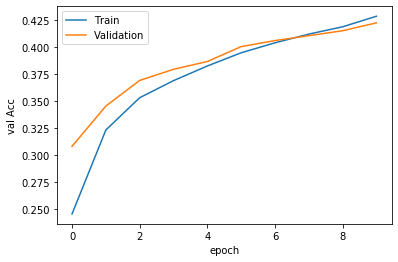

In [0]:
sns.lineplot(x='epoch', y='train Acc', data=results_CIFR_2, label='Train')
sns.lineplot(x='epoch', y='val Acc', data=results_CIFR_2, label='Validation')

In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


#This is defining a simple PyTorch laye to convert a tensor from (N, C, W, H) 
#to one of shape (N, D=C*W*H). Despite being useful, the pyTorch folks refuse to
#add one. We will use it later!
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
  

Now, I tried using a simple Convolution Neural Network to see how it fares to a fully connected network. 

In [0]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 32*32 
#How many channels are in the input?
C = 3
#How many classes are there?
classes = 10
#A simple convolutional network:
model_cnn = nn.Sequential(
  #Conv2d follows the pattern of:
  #Conv2d(# of input channels, #filters/output-channels, #filter-size)
  #For the manditory arguments. 
  nn.Conv2d(C, 32, (3,3), padding=1), 
  #We have to tell pyTorch exactly how many pixels to pad by. 
  #To get 'same' style padding, we want padding=floor(filter-size/2)
  nn.Tanh(),
  Flatten(), #Convert from (B, C, H, W) ->(B, D). This way we can use a Linear layer after
  nn.Linear(32*D, classes),
)


In [0]:
loss_func = nn.CrossEntropyLoss()
cnn_results = train_simple_network(model_cnn, loss_func, trainloader , val_loader=testloader, 
                                   score_funcs={'Accuracy': accuracy_score}, device='cuda', epochs=10)

In [0]:
cnn_results

,epoch,total time,train loss,val loss,train Accuracy,val Accuracy
0,0,39.275593,88658.136337,17178.339525,0.38366,0.4011
1,1,78.167266,84226.985209,16917.536083,0.42338,0.4143
2,2,117.418405,82285.856254,16784.031863,0.43478,0.4108
3,3,156.580904,80319.824944,16604.016656,0.44754,0.4237
4,4,195.470225,78983.431145,16561.340591,0.45408,0.4208
5,5,234.083059,78092.203174,16441.646952,0.45862,0.4292
6,6,274.239099,77315.167716,16438.830112,0.46258,0.4240
7,7,313.134087,76742.064642,16378.661061,0.46680,0.4262
8,8,352.329378,76063.911852,16358.350073,0.47130,0.4342
9,9,390.988383,74913.495876,16069.695029,0.47892,0.4392


There was not much variance in the accuracy for the fully connected and the CNN. Lets try a better version of the Convolution network.

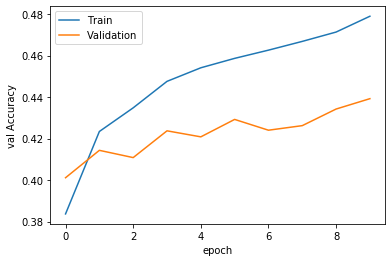

In [0]:
sns.lineplot(x='epoch', y='train Accuracy', data=cnn_results, label='Train')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results, label='Validation')

I tried using 2 layers of Maxpooling with our CNN. Pooling helps us solve a problem, that we aren't fully exploiting the spatial nature of our data. Similar to convolution, we will apply the same function to multiple locations in an image. We will generally stick to even sized pooling filters. And we will slide a function around the image that takes the maximum of all the inputs under consideration.

In [0]:
model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, 32, (3,3), padding=1), 
  nn.MaxPool2d((2,2)),
  nn.Tanh(),
  nn.Conv2d(32, 32, (3,3), padding=1), 
  nn.MaxPool2d((2,2)),
  nn.Tanh(),
  Flatten(), 
  #Why did we reduce the number of units into the Linear layer by a factor of 4? 
  #because pooling a 2x2 grid down to one value means we go from 4 values, down to 1. 
  nn.Linear(32*D//(4**2), classes),
)

In [0]:
loss_func = nn.CrossEntropyLoss()
cnn_results_2 = train_simple_network(model_cnn_pool, loss_func, trainloader , val_loader=testloader, 
                                   score_funcs={'Accuracy': accuracy_score}, device='cuda', epochs=10)

In [0]:
cnn_results_2

,epoch,total time,train loss,val loss,train Accuracy,val Accuracy
0,0,43.449665,87332.101562,15390.401550,0.39386,0.4584
1,1,87.264007,72841.144446,13786.111647,0.49166,0.5167
2,2,130.905933,66195.114995,12877.437470,0.53686,0.5467
3,3,174.458863,61619.533100,12080.274139,0.57154,0.5763
4,4,217.967097,58437.090399,11618.904753,0.59368,0.5881
5,5,260.798351,55815.079934,11160.450445,0.61132,0.6094
6,6,303.774626,53468.868149,10749.890140,0.62840,0.6181
7,7,347.544624,51342.740376,10391.469180,0.64264,0.6366
8,8,393.116859,49339.711416,10185.498148,0.65712,0.6411
9,9,437.894665,47628.731250,9958.046069,0.67036,0.6493


Our max-pooling feature certainly spiked the accuracy. Our model performed better than the previous versions.

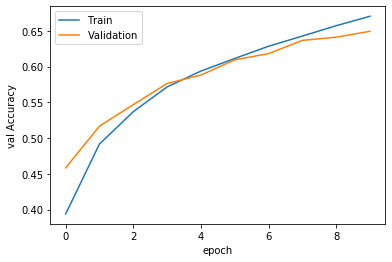

In [0]:
sns.lineplot(x='epoch', y='train Accuracy', data=cnn_results_2, label='Train')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results_2, label='Validation')

To further increase our performance, I doubled the number of filters, used three layers of convolutions and a filter size of 3.

In [0]:
model_cnn_pool_2 = nn.Sequential(
  nn.Conv2d(C, 64, (3,3), padding=1), 
  nn.MaxPool2d((2,2)),
  nn.Tanh(),
  nn.Conv2d(64, 32, (3,3), padding=1), 
  nn.MaxPool2d((2,2)),
  nn.Tanh(),
  nn.Conv2d(32,32,(3,3),padding=1),
  nn.Tanh(),
  Flatten(), 
  #Why did we reduce the number of units into the Linear layer by a factor of 4? 
  #because pooling a 2x2 grid down to one value means we go from 4 values, down to 1. 
  nn.Linear(32*D//(4**2), classes),
)

In [0]:
loss_func = nn.CrossEntropyLoss()
cnn_results_3 = train_simple_network(model_cnn_pool_2, loss_func, trainloader , val_loader=testloader, 
                                   score_funcs={'Accuracy': accuracy_score}, device='cuda', epochs=10)

In [0]:
cnn_results_3

,epoch,total time,train loss,val loss,train Accuracy,val Accuracy
0,0,48.075719,87703.496551,15187.882356,0.38150,0.4640
1,1,95.823295,72427.719196,13511.984398,0.48844,0.5245
2,2,144.149383,65070.365830,12519.087994,0.54164,0.5612
3,3,193.059013,60521.624260,11840.868168,0.57700,0.5864
4,4,241.042265,57434.109183,11182.169577,0.59784,0.6078
5,5,289.785408,54556.202449,10707.453406,0.61688,0.6244
6,6,337.951494,51678.047658,10374.442888,0.63696,0.6340
7,7,386.448176,49171.589891,9947.803828,0.65662,0.6497
8,8,435.302203,47257.766701,9626.391976,0.67040,0.6656
9,9,483.142049,45566.007225,9361.101266,0.68312,0.6721


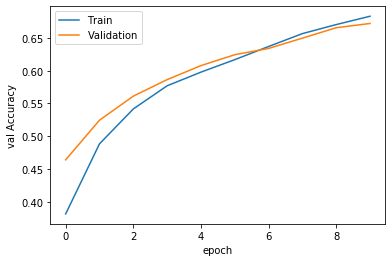

In [0]:
sns.lineplot(x='epoch', y='train Accuracy', data=cnn_results_3, label='Train')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results_3, label='Validation')

The model performed well and achieved a good accuracy of 67.21 in its validation. I believe the reason for better performance of CNN compared to a fully connected neural network is due to the feature extraction from each filter of CNN. Each filter is extracting a unique feature from an image and ultimately producing a convolved image which is smaller in size than the original image but has more features and value that can help learn that image more precisely and accurately. Additionally, CNN has max pooling which benefits spatial invariance. To be invariant to property X means that our output does not change based on X. We don't want translations (shifting up/down) to change our decisions. So we want to be translation invariant. (A similar property is being equivariant, meaning we recognize property X as having occurred, where invariance mean we can't even tell X happened - because it has NO impact on us). This benefits the model even the orientation of features in an image vary.